In [1]:
from selective_search import find_region_proposals
import cv2
import numpy as np
from model import initialize_model, load_model
from dataset import prepare_image
import torch
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

NUM_CLASSES = 21
image_size = (224,224)
MODEL_PATH = './checkpoints/regression 12-03-2021 22-38-46 epoch-2.pth'
model = initialize_model(NUM_CLASSES)
model, _, _ = load_model(model, MODEL_PATH)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(DEVICE)
print("Model Loaded...")
for param in model.parameters():
	param.requires_grad = False
torch.no_grad()
class_list = ['background','person','bird','cat','cow','dog','horse','sheep','aeroplane','bicycle','boat','bus','car','motorbike','train','bottle','chair','diningtable','pottedplant','sofa','tvmonitor']

Model Loaded...


In [2]:
torch_hstack = lambda a: torch.cat(a, dim=1)

def predict(image, batch_size=4):
    bboxes = find_region_proposals(image)
    print(len(bboxes), "proposals found")

    all_class_probs = []
    all_box_preds = []

    for i in tqdm(range(0,len(bboxes),batch_size)):
        current_bboxes = bboxes[i:i+batch_size]
        current_inputs = []
        for j in current_bboxes:
            x1,y1,x2,y2 = j
            current_inputs.append(prepare_image(cv2.resize(image[y1:y2,x1:x2], image_size)).unsqueeze(0))
        current_bboxes = torch.tensor(current_bboxes.astype('int32'))
        current_inputs = torch.cat(current_inputs).to(DEVICE)
        features = model.features(current_inputs).reshape(len(current_bboxes),-1)
        class_probs = model.classifier(features).cpu()
        box_preds = model.regressor(features).cpu()
        x1,y1,x2,y2 = [current_bboxes[:,[i]] for i in range(4)]
        box_preds *= torch_hstack([x2-x1,y2-y1,x2-x1,y2-y1]).type(torch.float32)
        box_preds = box_preds.long() + torch_hstack([x1,y1,x1,y1]).long()
        all_class_probs.append(class_probs)
        all_box_preds.append(box_preds)
    all_class_probs = torch.cat(all_class_probs)
    all_box_preds = torch.cat(all_box_preds)

    final_boxes = []
    class_preds = all_class_probs.argmax(axis=1)
    class_probs_max = all_class_probs.max(axis=1)

    try:
        boxes_to_keep = torchvision.ops.boxes.batched_nms(all_box_preds.to(torch.float32), all_class_probs, class_preds, 0.7)
        final_boxes = torch_hstack([class_preds[boxes_to_keep].reshape(-1,1),all_box_preds[boxes_to_keep]])
        return final_boxes
    except Exception as e:
        print("ERROR occured:", e)
        return None, all_box_preds, all_class_probs

In [3]:
image_path = r"C:\Users\trizo\Downloads\Documents\Sem6\CV\Project\VOC2012\JPEGImages\2007_000027.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
boxes = predict(image)

  0%|                                                                                          | 0/316 [00:00<?, ?it/s]

1263 proposals found


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [03:48<00:00,  1.38it/s]

ERROR occured: nms(): incompatible function arguments. The following argument types are supported:
    1. (arg0: at::Tensor, arg1: at::Tensor, arg2: float) -> at::Tensor

Invoked with: tensor([[ 470.,  286.,  481.,  301.],
        [ 121.,  255.,  151.,  272.],
        [ 322.,  216.,  407.,  349.],
        ...,
        [  -4.,  -62.,  276.,  154.],
        [ 598.,  493.,  683., 1070.],
        [  14.,   69.,  348.,  572.]]), torch.return_types.max(
values=tensor([ 6.5174, 11.0409,  9.1401,  ...,  3.0159,  3.3983,  3.9417]),
indices=tensor([0, 0, 0,  ..., 0, 1, 0])), 0.7


In [22]:
all_box_preds, all_class_probs = boxes[1:]
class_preds = all_class_probs.argmax(axis=1)
boxes_to_keep = torchvision.ops.boxes.batched_nms(all_box_preds.type(torch.float32), all_class_probs, class_preds, 0.5)
final_boxes = torch_hstack([class_preds[boxes_to_keep].reshape(-1,1),all_box_preds[boxes_to_keep]])
print(final_boxes[torch.where(final_boxes[:,0]!=0)].shape)

torch.Size([31, 5])


In [8]:
def draw_boxes(image, boxes):
	new_image = image.copy()
	for box in boxes:
		class_ind = int(box[0])
		x1,y1,x2,y2 = tuple(map(int, box[1:]))
		new_image = cv2.rectangle(new_image, (x1,y1), (x2,y2), (255,0,0), 3)
		cv2.putText(new_image, class_list[class_ind], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
	return new_image

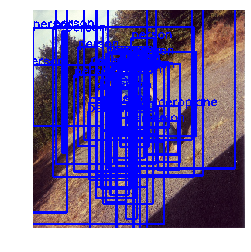

In [14]:
predicted = cv2.cvtColor(draw_boxes(image, final_boxes[torch.where(final_boxes[:,0]!=0)]), cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(predicted)
plt.show()

In [18]:
final_boxes[torch.where(final_boxes[:,0]!=0)][:,0]

tensor([1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

In [23]:
mask = torch.where(class_preds!=0)
boxes_to_keep = torchvision.ops.boxes.batched_nms(all_box_preds.type(torch.float32)[mask], all_class_probs[mask], class_preds[mask], 0.5)
boxes_to_keep.shape

torch.Size([15])